In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

In [3]:
SIZE_FULL = 768 # original dataset's images size
SIZE = 256 #size used for using in model (3x3 squares to make original image)

In [4]:
!python -V

Python 3.10.12


In [5]:
def crop3x3(img, i):
    """img: np.ndarray - original image 768x768
       i: int 0-8 - image index from crop: 0 1 2
                                           3 4 5
                                           6 7 8
       returns: image 256x256 
    """
    return img[(i//3)*SIZE: ((i//3)+1)*SIZE,(i%3)*SIZE: (i%3+1)*SIZE]


def crop3x3_mask(img):
    """Returns crop image, crop index with maximum ships area"""
    i = K.argmax((
        K.sum(crop3x3(img, 0)),
        K.sum(crop3x3(img, 1)),
        K.sum(crop3x3(img, 2)),
        K.sum(crop3x3(img, 3)),
        K.sum(crop3x3(img, 4)),
        K.sum(crop3x3(img, 5)),
        K.sum(crop3x3(img, 6)),
        K.sum(crop3x3(img, 7)),
        K.sum(crop3x3(img, 8)),
    ))
    return (crop3x3(img, i), i)

In [6]:
# https://www.kaggle.com/code/stainsby/fast-tested-rle/notebook
def decode(mask_rle):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    img=np.zeros(SIZE_FULL*SIZE_FULL, dtype=np.float32)
    if not(type(mask_rle) is float):
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1.0
    return img.reshape((SIZE_FULL, SIZE_FULL)).T

In [7]:
class TrainDataGenerator(tfk.utils.Sequence):

    def __init__(self, datapath ,batch_size, df_mask: pd.DataFrame):
        self.datapath = datapath
        self.batch_size = batch_size
        self.df =  df_mask.sample(frac=1)
        self.l = len(self.df)//batch_size

    def __len__(self):
        return self.l

    def on_epoch_end(self):
        pass

    def __getitem__(self, index):
        mask = np.empty((self.batch_size, SIZE , SIZE), np.float32)
        image = np.empty((self.batch_size, SIZE, SIZE, 3), np.float32)
        
        for b in range(self.batch_size):
            temp = tfk.preprocessing.image.load_img(self.datapath + '/' + self.df.iloc[index*self.batch_size+b]['ImageId'])
            temp = tfk.preprocessing.image.img_to_array(temp)/255
        
            mask[b], i = crop3x3_mask( # decoding mask from run-length format, and cropping part with maximum ship's area(№ i)
                decode(
                    self.df.iloc[index*self.batch_size+b]['EncodedPixels']
                )
            ) 
            image[b] = crop3x3(temp, i) # using corresponding to mask crop of image (№ i)
            
        return image, mask

In [8]:
empty, has_ships = 1000, 9000
df = pd.read_csv("/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv")
df = pd.concat([df[df["EncodedPixels"].isna()].sample(empty), df[~df["EncodedPixels"].isna()].sample(has_ships)])

## UNET

In [9]:
# dropout = 0.2
dropout = 0.2

k =2
def dconv(prev, filters, kernel_size=3):
    prev = tfl.BatchNormalization()(prev)
    prev = tfl.Conv2D(filters, kernel_size, padding="same", activation="elu", kernel_initializer= 'he_normal')(prev)
    prev = tfl.Dropout(dropout)(prev)
    prev = tfl.Conv2D(filters, kernel_size, padding="same", activation="elu", kernel_initializer= 'he_normal')(prev)
    return prev
    


def down(prev, filters, kernel_size=3): 
    skip = dconv(prev, filters, kernel_size)
    prev = tfl.MaxPool2D(strides=2, padding='valid')(skip)
    return prev, skip


def bridge(prev, filters,kernel_size=3):  
    prev = dconv(prev, filters, kernel_size)
    prev = tfl.Conv2DTranspose(filters // 2, 2, strides=(2, 2))(prev)
    return prev


def up(prev, skip, filters, kernel_size=3):  
    prev = tfl.concatenate([prev, skip], axis=3) 
    prev = tfl.Dropout(dropout)(prev)
    prev = dconv(prev, filters, kernel_size)
    prev = tfl.Conv2DTranspose(filters // 2, 2, strides=(2, 2))(prev)
    return prev


def last(prev, skip, filters,kernels_size=(3,3)):
    prev = tfl.concatenate([prev, skip], axis=3)
    prev = tfl.Dropout(dropout)(prev)
    prev = tfl.Conv2D(filters, kernels_size[0], padding="same",activation="elu", kernel_initializer= 'he_normal')(prev)
    prev = tfl.Conv2D(filters, kernels_size[1], padding="same",activation="elu", kernel_initializer= 'he_normal')(prev)
    prev = tfl.Conv2D(filters=1, kernel_size=1,padding="same", activation="sigmoid")(prev)
    return prev


def unet_model(input_shape):
    inp = tfk.Input(shape=input_shape)
    inp = tfl.BatchNormalization()(inp)
    out, skip_1 = down(inp, k*16)
    out, skip_2 = down(out, k*32)
    out, skip_3 = down(out, k*64)
    out, skip_4 = down(out, k*128)
    out = bridge(out, k*256)
    out = up(out, skip_4, k*128)
    out = up(out, skip_3, k*64)
    out = up(out, skip_2, k*32)
    out = last(out, skip_1, k*16)

    model = tfk.Model(inputs=inp, outputs=out)
    return model

### Losses

In [10]:
import keras.backend as K

In [11]:
def dice_score(y_true, y_pred):
    return (2.0*K.sum(y_pred * y_true)+0.0001) / (K.sum(y_true)+ K.sum(y_pred)+0.0001)

In [12]:
def BFCE_dice(y_true, y_pred):
    return  K.binary_focal_crossentropy(y_true, y_pred)+  (1-dice_score(y_true, y_pred))*0.1

In [13]:
def BCE_dice(y_true, y_pred):
    return  K.binary_crossentropy(y_true, y_pred)+  (1-dice_score(y_true, y_pred))

### Train

In [14]:
batch_size = 16
train_df, valid_df = train_test_split(df, test_size=0.2)
train = TrainDataGenerator("/kaggle/input/airbus-ship-detection/train_v2", batch_size, train_df)
valid = TrainDataGenerator("/kaggle/input/airbus-ship-detection/train_v2", batch_size, valid_df)
model = unet_model((SIZE, SIZE, 3))

In [15]:
model.compile(tf.keras.optimizers.Adam(0.0001) , BCE_dice  , dice_score)

In [16]:
callback = tfk.callbacks.ModelCheckpoint("./models/model.{epoch:02d}-{val_loss:.4f}-dice:{val_dice_score:.4f}.h5", "val_loss", save_best_only=True, save_weights_only=True)

In [17]:
history = model.fit(train, validation_data=valid, batch_size = batch_size,epochs=24,verbose=1, callbacks=[callback] )

Epoch 1/24


2023-12-11 12:53:37.900660: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 [==============================] - 383s 724ms/step - loss: 0.7283 - dice_score: 0.3794 - val_loss: 0.6567 - val_dice_score: 0.4403
Epoch 2/24
500/500 [==============================] - 303s 607ms/step - loss: 0.5853 - dice_score: 0.4953 - val_loss: 0.6102 - val_dice_score: 0.4654
Epoch 3/24
500/500 [==============================] - 304s 608ms/step - loss: 0.5466 - dice_score: 0.5273 - val_loss: 0.6044 - val_dice_score: 0.4742
Epoch 4/24
500/500 [==============================] - 305s 611ms/step - loss: 0.5184 - dice_score: 0.5513 - val_loss: 0.5618 - val_dice_score: 0.5118
Epoch 5/24
500/500 [==============================] - 310s 620ms/step - loss: 0.4951 - dice_score: 0.5706 - val_loss: 0.5680 - val_dice_score: 0.5102
Epoch 6/24
500/500 [==============================] - 307s 614ms/step - loss: 0.4804 - dice_score: 0.5831 - val_loss: 0.5424 - val_dice_score: 0.5328
Epoch 7/24
500/500 [==============================] - 305s 610ms/step - loss: 0.4617 - dice_score: 0.5997 - val

In [18]:
model.compile(tf.keras.optimizers.Adam(0.00005) , BCE_dice  , dice_score)
history2 = model.fit(train, validation_data=valid, batch_size = batch_size,epochs=6,verbose=1, callbacks=[callback])

Epoch 1/6


2023-12-11 15:15:50.329366: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 [==============================] - 313s 605ms/step - loss: 0.2756 - dice_score: 0.7610 - val_loss: 0.4319 - val_dice_score: 0.6245
Epoch 2/6
500/500 [==============================] - 295s 590ms/step - loss: 0.2653 - dice_score: 0.7700 - val_loss: 0.4353 - val_dice_score: 0.6241
Epoch 3/6
500/500 [==============================] - 293s 586ms/step - loss: 0.2580 - dice_score: 0.7765 - val_loss: 0.4186 - val_dice_score: 0.6382
Epoch 4/6
500/500 [==============================] - 293s 586ms/step - loss: 0.2531 - dice_score: 0.7807 - val_loss: 0.4363 - val_dice_score: 0.6264
Epoch 5/6
500/500 [==============================] - 296s 593ms/step - loss: 0.2478 - dice_score: 0.7855 - val_loss: 0.4317 - val_dice_score: 0.6280
Epoch 6/6
500/500 [==============================] - 292s 585ms/step - loss: 0.2450 - dice_score: 0.7878 - val_loss: 0.4374 - val_dice_score: 0.6229


In [19]:
model.compile(tf.keras.optimizers.Adam(0.00001) , BCE_dice  , dice_score)
history3 = model.fit(train, validation_data=valid, batch_size = batch_size,epochs=6,verbose=1, callbacks=[callback])

Epoch 1/6


2023-12-11 15:48:28.767037: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 [==============================] - 304s 587ms/step - loss: 0.2290 - dice_score: 0.8016 - val_loss: 0.4235 - val_dice_score: 0.6371
Epoch 2/6
500/500 [==============================] - 289s 578ms/step - loss: 0.2243 - dice_score: 0.8059 - val_loss: 0.4179 - val_dice_score: 0.6415
Epoch 3/6
500/500 [==============================] - 289s 579ms/step - loss: 0.2216 - dice_score: 0.8084 - val_loss: 0.4230 - val_dice_score: 0.6366
Epoch 4/6
500/500 [==============================] - 291s 582ms/step - loss: 0.2187 - dice_score: 0.8109 - val_loss: 0.4173 - val_dice_score: 0.6409
Epoch 5/6
500/500 [==============================] - 290s 581ms/step - loss: 0.2164 - dice_score: 0.8128 - val_loss: 0.4328 - val_dice_score: 0.6278
Epoch 6/6
500/500 [==============================] - 290s 580ms/step - loss: 0.2146 - dice_score: 0.8144 - val_loss: 0.4212 - val_dice_score: 0.6379


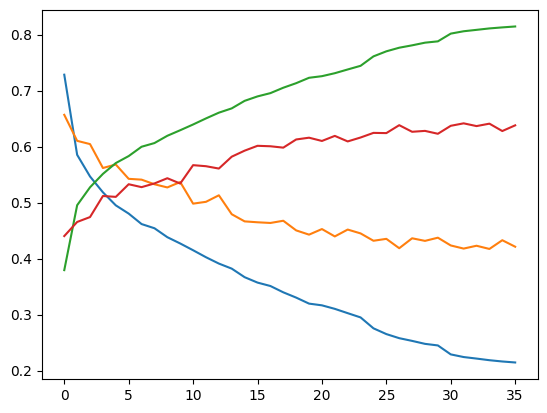

In [21]:
L = []
L.extend(history.history['loss'])
L.extend(history2.history['loss'])
L.extend(history3.history['loss'])
LV=[]
LV.extend(history.history['val_loss'])
LV.extend(history2.history['val_loss'])
LV.extend(history3.history['val_loss'])

S = []
S.extend(history.history['dice_score'])
S.extend(history2.history['dice_score'])
S.extend(history3.history['dice_score'])


V = []
V.extend(history.history['val_dice_score'])
V.extend(history2.history['val_dice_score'])
V.extend(history3.history['val_dice_score'])

plt.plot(L)
plt.plot(LV)
plt.plot(S)
plt.plot(V)
